# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

A: The data represents current and previous marketing campains which involved getting potential clients to subscribe to a long term deposit application with what the bank considered a good interest rate.  Furthermore, there was some information retained from the previous campain for each person contacted, which included the previous compains success.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

#### Dataset Characteristics
- Data is imbalanced with regards to using the success vs failure class/column 'y': 
  - No  : 36548
  - Yes : 4640
- No NaN or empty feature/column values detected

In [107]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time

In [108]:
# read raw banking data from CSV file
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

# rename feature columns to something more useful
df.columns = ['age', 'job_type', 'marital_status', 'education', 'credit_in_default', 'housing_loan', 'personal_loan', 'contact_method', 'month_last_contact', 'dayOfWeek_last_contact', 'contact_duration_seconds', 'contact_attempts_during_campaign', 'days_since_last_contact', 'contact_attempts_previous_camapain', 'outcome_previous_campain', 'employment_variation_rate_quarteryly', 'consumer_price_index_monthly', 'consumer_confidence_index_monthly', 'euribor3_monthly_rate_daily', 'number_employed_quarterly', 'subscribed']

In [109]:
# dataset balance of subscribed class (derived from column 'y').
df['subscribed'].value_counts()

subscribed
no     36548
yes     4640
Name: count, dtype: int64

In [110]:
# view data set
df.head(-10)

,age,job_type,marital_status,education,credit_in_default,housing_loan,personal_loan,contact_method,month_last_contact,dayOfWeek_last_contact,...,contact_attempts_during_campaign,days_since_last_contact,contact_attempts_previous_camapain,outcome_previous_campain,employment_variation_rate_quarteryly,consumer_price_index_monthly,consumer_confidence_index_monthly,euribor3_monthly_rate_daily,number_employed_quarterly,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41173,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,yes
41174,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,1,1,6,success,-1.1,94.767,-50.8,1.031,4963.6,yes
41175,34,student,single,unknown,no,yes,no,cellular,nov,thu,...,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,no
41176,38,housemaid,divorced,high.school,no,yes,yes,cellular,nov,thu,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.031,4963.6,no


In [111]:
# view new feature/column names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   41188 non-null  int64  
 1   job_type                              41188 non-null  object 
 2   marital_status                        41188 non-null  object 
 3   education                             41188 non-null  object 
 4   credit_in_default                     41188 non-null  object 
 5   housing_loan                          41188 non-null  object 
 6   personal_loan                         41188 non-null  object 
 7   contact_method                        41188 non-null  object 
 8   month_last_contact                    41188 non-null  object 
 9   dayOfWeek_last_contact                41188 non-null  object 
 10  contact_duration_seconds              41188 non-null  int64  
 11  contact_attempt

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - (Month of Contact) - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - (Call Duration) - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - (Number of Previous Contacts) - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - (Days Since Last Contact) - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - (Last Contact Results) - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```

The following Python code shall transform the columns using the OneHotEncoder.  Furthermore, any columns generated from data that equaled the value of 'unknown' shall be removed.

In [130]:
# get column names for numeric and catagorical features
categorical_columns = df.drop('subscribed', axis=1).select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# features that require OneHotEncoding
print('Catagorical columns that required encoding into numeric values using OneHotEncoder')
for category_name in categorical_columns :
    catagory_count = df[category_name].value_counts()
    print (catagory_count)
    print ('\n')



Catagorical columns that required encoding into numeric values using OneHotEncoder
job_type
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


marital_status
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64


credit_in_default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


housing_loan
yes        21576
no         18622
unknown      990
Name: count, dtype: int64


personal_loan
no         33950

In [113]:
print('categorical columns: ', categorical_columns)

# create feature DataFrame
X = df.drop('subscribed', axis=1)

# encode columns with category data and remove unwanted columns
for category_name in categorical_columns :
    encoder = OneHotEncoder() # drop='first'...doing this manually

    # transform category data
    encoded_data = encoder.fit_transform(X[[category_name]])

    # Convert the encoded data to a DataFrame
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out([category_name]))

    # Drop OHE created: 'unknown' categorical column from DataFrame...this replaces drop='first' for OHE
    if category_name + '_unknown' in encoded_df.columns:
        encoded_df.drop([category_name + '_unknown'], axis=1, inplace=True)

    elif encoded_df.columns.size > 2: 
        # drop first column if 'unknown' column doesn't exist and there are more than two columns total, generated by OHE
        encoded_df.drop([encoded_df.columns[0]], axis=1, inplace=True) 

    print('remaining columns from encoder for category ['+ category_name +']: ', encoded_df.columns.tolist())

    # Concatenate the encoded DataFrame with the original DataFrame
    X = pd.concat([X, encoded_df], axis=1)

    # Drop original categorical column from DataFrame
    X.drop([category_name], axis=1, inplace=True)



categorical columns:  ['job_type', 'marital_status', 'education', 'credit_in_default', 'housing_loan', 'personal_loan', 'contact_method', 'month_last_contact', 'dayOfWeek_last_contact', 'outcome_previous_campain']
remaining columns from encoder for category [job_type]:  ['job_type_admin.', 'job_type_blue-collar', 'job_type_entrepreneur', 'job_type_housemaid', 'job_type_management', 'job_type_retired', 'job_type_self-employed', 'job_type_services', 'job_type_student', 'job_type_technician', 'job_type_unemployed']
remaining columns from encoder for category [marital_status]:  ['marital_status_divorced', 'marital_status_married', 'marital_status_single']
remaining columns from encoder for category [education]:  ['education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree']
remaining columns from encoder for category [credit_in_default]:  ['credit_in_default_no', 'credit_in_

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective:
The task at hand is to create a model that shall be used to predict if a potential customer shall subscribe to the banks product using the feature data provided from previous campains as well as the outcome from said campains as the target.  In the end, this model shall allow the business (bank) to target potential customer's more accurately.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [114]:
# OneHotEncoding performed in previous step so we only need a standard scaler

# create preprocessor using StandardScaler to encode all feature data which
# is now numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', StandardScaler(), X.columns.tolist())
    ])

# extract target
y = df.subscribed

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [116]:
# the baseline models using default hyperparameters
models = {
    'knn': (KNeighborsClassifier()),
    'logisticregression': (LogisticRegression()),
    'svc': (SVC()),
    'decisiontreeclassifier': (DecisionTreeClassifier())
}


In [117]:
results = []

# Execute pipeline containing encoded data
# and target models
for name, (model) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid={}, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    # Append the results
    results.append([name, train_score, test_score, fit_time])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'average fit time'])
results_df.reset_index(inplace=True)

results_df.to_json('data/baseline_model_results.json', orient='records', double_precision=10)

{}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', StandardScaler(),
                                                  ['age',
                                                   'contact_duration_seconds',
                                                   'contact_attempts_during_campaign',
                                                   'days_since_last_contact',
                                                   'contact_attempts_previous_camapain',
                                                   'employment_variation_rate_quarteryly',
                                                   'consumer_price_index_monthly',
                                                   'consumer_confidence_index_monthly',
                                                   'euribor3_monthly_ra...
                                                   'job_type_self-employed',
                                                   'job_type_services',
        

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [118]:
#Logistic regregession was used to model data in previous step

### Problem 9: Score the Model

What is the accuracy of your model?

In [119]:
# baseline accuracy for each model is as follows
results_df.loc[:, ['model', 'test score']]

,model,test score
0,knn,0.896091
1,logisticregression,0.911265
2,svc,0.908230
3,decisiontreeclassifier,0.883588


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [120]:
baseline_df = pd.read_json(r'data/baseline_model_results.json')
baseline_df[['model', 'train score','test score','average fit time']]

,model,train score,test score,average fit time
0,knn,0.920759,0.896091,5.004178
1,logisticregression,0.911806,0.911265,2.002720
2,svc,0.926555,0.908230,53.106882
3,decisiontreeclassifier,1.000000,0.883588,1.721851


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### 11A Selecting the best features
Using six random coefficients ranging from [1.00000000e-05 to 3.16227766e+00] the following was done in an effort to extract the most performant features either found in or generated from the current dataset:
- Using the SelectFromModel class the optimal features were chosen using the previously mentioned coefficients
- A data dictionary containing the coefficients as the key and the list of optimal features as the value was then created and saved to file

In [121]:
# create list of best coefficients
# Cs = np.logspace(-5, .5)
# Cs
    #    1.00000000e-05, 1.29492584e-05, 1.67683294e-05, 2.17137430e-05,
    #    2.81176870e-05, 3.64103195e-05, 4.71486636e-05, 6.10540230e-05,
    #    7.90604321e-05, 1.02377397e-04, 1.32571137e-04, 1.71669791e-04,
    #    2.22299648e-04, 2.87861559e-04, 3.72759372e-04, 4.82695744e-04,
    #    6.25055193e-04, 8.09400122e-04, 1.04811313e-03, 1.35722878e-03,
    #    1.75751062e-03, 2.27584593e-03, 2.94705170e-03, 3.81621341e-03,
    #    4.94171336e-03, 6.39915234e-03, 8.28642773e-03, 1.07303094e-02,
    #    1.38949549e-02, 1.79929362e-02, 2.32995181e-02, 3.01711481e-02,
    #    3.90693994e-02, 5.05919749e-02, 6.55128557e-02, 8.48342898e-02,
    #    1.09854114e-01, 1.42252931e-01, 1.84206997e-01, 2.38534401e-01,
    #    3.08884360e-01, 3.99982340e-01, 5.17947468e-01, 6.70703561e-01,
    #    8.68511374e-01, 1.12465782e+00, 1.45634848e+00, 1.88586328e+00,
    #    2.44205309e+00, 3.16227766e+00

# randomely selected 6 of the 50 coefficients
Cs = [1.00000000e-05, 8.09400122e-04, 2.27584593e-03, 6.55128557e-02, 5.17947468e-01, 3.16227766e+00]



In [ ]:
# Logistic Regression - feature selection using L1 as penalty

# built convergence table to see what were, optimally, the best features.
# ...the information from this effort matched the output from the SelectFromModel() which, in the end, what was eventually used.
coef_list = []
for C in Cs:
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42, max_iter=10000).fit(X_train, y_train)
    coef_list.append(list(lr.coef_[0]))

coef_df = pd.DataFrame(coef_list, columns=X_train.columns)
coef_df.index = Cs
coef_df


,age,contact_duration_seconds,contact_attempts_during_campaign,days_since_last_contact,contact_attempts_previous_camapain,employment_variation_rate_quarteryly,consumer_price_index_monthly,consumer_confidence_index_monthly,euribor3_monthly_rate_daily,number_employed_quarterly,...,month_last_contact_may,month_last_contact_nov,month_last_contact_oct,month_last_contact_sep,dayOfWeek_last_contact_mon,dayOfWeek_last_contact_thu,dayOfWeek_last_contact_tue,dayOfWeek_last_contact_wed,outcome_previous_campain_nonexistent,outcome_previous_campain_success
0.000010,0.000000,0.003341,0.000000,-0.002553,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000160,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000809,0.002825,0.004074,0.000000,-0.002135,0.000000,0.000000,0.008998,0.025341,-0.387646,-0.000044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.002276,0.002611,0.004280,-0.002332,-0.001883,0.000000,0.000000,0.018877,0.042546,-0.525216,-0.000067,...,-0.101594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.065513,0.000224,0.004591,-0.050540,-0.001818,-0.083217,-0.540330,0.407446,0.012099,0.134847,-0.007897,...,-0.777935,-0.329331,0.000000,-0.017381,-0.116550,0.000000,0.040399,0.061220,0.320436,0.000000
0.517947,0.000224,0.004644,-0.051014,-0.001138,-0.038868,-0.917402,0.560838,-0.005178,0.590992,-0.011270,...,-0.675187,-0.545385,-0.022460,-0.194112,-0.105760,0.079433,0.106130,0.145883,0.420854,0.752199
3.162278,0.000501,0.004641,-0.051920,-0.001062,-0.009599,-0.768655,0.470012,0.000467,0.398316,-0.009486,...,-0.692182,-0.465509,0.050719,-0.153209,-0.097571,0.088346,0.120733,0.159441,0.458334,0.847519


In [122]:
features_list = coef_df.columns.to_list()
print ('List of all features found in baseline DataFrame')
features_list

# # display the best features
# column_list = []
# for idx in range(len(features_list)) :
#     column_list.append(features_list[idx])

#     if len(column_list) == 5 :
#         plt.figure(figsize = (12, 5))
#         plt.semilogx(coef_df.loc[:, column_list])
#         plt.gca().invert_xaxis()
#         plt.grid()
#         plt.legend(column_list);
#         plt.title('Increasing Regularization Bank Campain Features')
#         plt.xlabel("Increasing 1/C")
#         plt.savefig('images/best_lr_features_using_coef_l1_' + str(idx) + '.png')

#         column_list = []

List of all features found in baseline DataFrame


['age',
 'contact_duration_seconds',
 'contact_attempts_during_campaign',
 'days_since_last_contact',
 'contact_attempts_previous_camapain',
 'employment_variation_rate_quarteryly',
 'consumer_price_index_monthly',
 'consumer_confidence_index_monthly',
 'euribor3_monthly_rate_daily',
 'number_employed_quarterly',
 'job_type_admin.',
 'job_type_blue-collar',
 'job_type_entrepreneur',
 'job_type_housemaid',
 'job_type_management',
 'job_type_retired',
 'job_type_self-employed',
 'job_type_services',
 'job_type_student',
 'job_type_technician',
 'job_type_unemployed',
 'marital_status_divorced',
 'marital_status_married',
 'marital_status_single',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'credit_in_default_no',
 'credit_in_default_yes',
 'housing_loan_no',
 'housing_loan_yes',
 'personal_loan_no',
 'personal_loan_yes',
 'contact_method_cellular'

In [123]:
# Use SelectFromModel to get the best features for the following coefficients defined previously in Cs variable
# Cs = [1.00000000e-05, 8.09400122e-04, 2.27584593e-03, 6.55128557e-02, 5.17947468e-01, 3.16227766e+00]

lr_selected_feature_results = {}
for C in Cs:
    selector = SelectFromModel(LogisticRegression(C=C, penalty='l1', solver='liblinear', max_iter=10000, random_state=42))
    ans = selector.fit_transform(X_train, y_train)
    selected_features = selector.get_feature_names_out()

    # create data dictionary of coefficients associated with target feature set
    lr_selected_feature_results[C] = selected_features
    print("C: ", C, ' , Feature set: ', selected_features)  # get best feature names that converged


C:  1e-05  , Feature set:  ['contact_duration_seconds' 'days_since_last_contact'
 'number_employed_quarterly']
C:  0.000809400122  , Feature set:  ['age' 'contact_duration_seconds' 'days_since_last_contact'
 'consumer_price_index_monthly' 'consumer_confidence_index_monthly'
 'euribor3_monthly_rate_daily' 'number_employed_quarterly']
C:  0.00227584593  , Feature set:  ['age' 'contact_duration_seconds' 'contact_attempts_during_campaign'
 'days_since_last_contact' 'consumer_price_index_monthly'
 'consumer_confidence_index_monthly' 'euribor3_monthly_rate_daily'
 'number_employed_quarterly' 'month_last_contact_may']
C:  0.0655128557  , Feature set:  ['age' 'contact_duration_seconds' 'contact_attempts_during_campaign'
 'days_since_last_contact' 'contact_attempts_previous_camapain'
 'employment_variation_rate_quarteryly' 'consumer_price_index_monthly'
 'consumer_confidence_index_monthly' 'euribor3_monthly_rate_daily'
 'number_employed_quarterly' 'job_type_blue-collar' 'job_type_retired'
 'job

In [124]:
def ndarray_to_list(obj):
    """
    Converts ndarray objects to lists for JSON serialization.

    Args:
        obj: Any object.

    Returns:
        The object converted to a list if it's an ndarray, otherwise the original object.
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type '{obj.__class__.__name__}' is not JSON serializable")

# save data dictionary of coefficients and features to file
with open('data/lr_selected_feature_results.json', 'w') as fp:
    json.dump(lr_selected_feature_results, fp, sort_keys=True, default=ndarray_to_list)


#### 11B Improving performance of the model derived using Logistic Regression
Using six random coefficients ranging from [1.00000000e-05 to 3.16227766e+00] the LogisticRegression class was used to create and score six models with the following parameters:
  - max iterations: 10000
  - C : provided by data dictionary stored in 'lr_selected_feature-results.json' file
  - random state: 42
  - penalty: L1 and L2 : used as a hyperparameter in GridSearchCV
  - solver: liblinear
  
  When performing the grid-search K-fold cross validation was used with 5 folds.
  For each Coefficient (C) an associated list of features was transformed, and used for fitting and scoring each model.

In [125]:
def load_map_from_json(file_path):
    """
    Loads a map (dictionary) from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The map loaded from the JSON file, or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
         print(f"An unexpected error occurred: {e}")
         return None


In [ ]:
# load data dictionary with selected features and coefficients
lr_selected_feature_results = load_map_from_json('data/lr_selected_feature_results.json')

# Score LogisticRegression models with new hyperparameters while using coefficients and features from data dictionary saved in previous step
best_model_results = []
for coef, selected_feature_list in lr_selected_feature_results.items() :
    hyperparams = {
            'logisticregression__penalty': ['l1', 'l2'],
        }
    preprocessor = ColumnTransformer(
        transformers=[
            ('selected_features', StandardScaler(), selected_feature_list),
        ])
    model_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('logisticregression', LogisticRegression(C=float(coef), solver='liblinear', max_iter=10000, random_state=42))
                    ])
    model_grid = GridSearchCV(model_pipe, param_grid=hyperparams, cv=5, n_jobs=-1)
    
    start_time = time.time()
    model_grid.fit(X_train[selected_feature_list], y_train)
    fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time'])

    # Get the best estimator
    best_model = model_grid.best_estimator_
    print('Best params: ', model_grid.best_params_)
    print('Best estimator: ', model_grid.best_estimator_)

    train_score = best_model.score(X_train[selected_feature_list], y_train)
    test_score = best_model.score(X_test[selected_feature_list], y_test)

    best_model_results.append([float(coef), len(selected_feature_list), model_grid.best_params_, train_score, test_score, fit_time])

best_model_results_df = pd.DataFrame(best_model_results, columns=['coef', 'feature count', 'best params', 'train score', 'test score', 'average fit time'])
best_model_results_df.reset_index(inplace=True)
best_model_results_df.to_json('data/lr_model_per_coef_results_df.json', orient='records', double_precision=10)



Best params:  {'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best estimator:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['contact_duration_seconds',
                                                   'days_since_last_contact',
                                                   'number_employed_quarterly'])])),
                ('logisticregression',
                 LogisticRegression(C=1e-05, max_iter=10000, random_state=42,
                                    solver='liblinear'))])
Best params:  {'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best estimator:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
              

#### 11B Final Results for Logistic Regression
All of the models tested exibited similar accuracy (90% - 91%) where the fit time seemed to be much better when using smaller feature sets.  With that said any of the models that used the feature sets of size 3, 7 or 9 would be the optimum choice.  This can be seen in the following table.

In [58]:
lr_results_df = pd.read_json('data/lr_model_per_coef_results_df.json')
lr_results_df

,index,coef,feature count,best params,train score,test score,average fit time
0,0,0.000010,3,"{'logisticregression__penalty': 'l2', 'logisti...",0.903490,0.901068,0.052101
1,1,0.000809,7,"{'logisticregression__penalty': 'l2', 'logisti...",0.906586,0.904224,0.139867
2,2,0.002276,9,"{'logisticregression__penalty': 'l2', 'logisti...",0.908316,0.907016,0.166232
3,3,0.065513,33,"{'logisticregression__penalty': 'l2', 'logisti...",0.911168,0.910537,2.138214
4,4,0.517947,46,"{'logisticregression__penalty': 'l2', 'logisti...",0.911806,0.911265,4.218438
5,5,3.162278,50,"{'logisticregression__penalty': 'l2', 'logisti...",0.911745,0.911022,6.303652


#### 11C Improving performance of the model derived using K-Nearest-Neighbor (KNN)
The following hyperparameter types were used in this exercise
- n_neighbors: ranging from 1 - 22, incrementing each value by 2
- weights : 'uniform' and 'distance'
- metric (p): 'euclidean' (p=2) and 'manhattan' (p=1). 

When performing the grid-search K-fold cross validation was used with 5 folds.

Note: The same features selected for the models derived in the previous step (11B) where used here.


In [126]:
# load data dictionary with selected features
lr_selected_feature_results = load_map_from_json('data/lr_selected_feature_results.json')

hyperparams = {'knn__n_neighbors': list(range(1, 22, 2)),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2]}

# Evaluate KNeighborsClassifier (KNN) models for each set of features
best_model_results = []
for selected_feature_list in lr_selected_feature_results.values() :
    preprocessor = ColumnTransformer(
        transformers=[
            ('selected_features', StandardScaler(), selected_feature_list),
        ])
    model_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('knn', KNeighborsClassifier())
                    ])
    model_grid = GridSearchCV(model_pipe, param_grid=hyperparams, cv=5, n_jobs=-1)
    
    start_time = time.time()
    model_grid.fit(X_train[selected_feature_list], y_train)
    fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time'])

    # Get the best estimator
    best_model = model_grid.best_estimator_
    print(model_grid.best_params_)
    print(model_grid.best_estimator_)

    train_score = best_model.score(X_train[selected_feature_list], y_train)
    test_score = best_model.score(X_test[selected_feature_list], y_test)

    best_model_results.append([len(selected_feature_list), model_grid.best_params_, train_score, test_score, fit_time])

# Create the results DataFrame
best_model_results_df = pd.DataFrame(best_model_results, columns=['feature count', 'best params', 'train score', 'test score', 'average fit time'])
best_model_results_df.reset_index(inplace=True)
best_model_results_df.to_json('data/knn_model_results_df.json', orient='records', double_precision=10)


{'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'uniform'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['contact_duration_seconds',
                                                   'days_since_last_contact',
                                                   'number_employed_quarterly'])])),
                ('knn', KNeighborsClassifier(n_neighbors=19, p=1))])
{'knn__n_neighbors': 21, 'knn__p': 2, 'knn__weights': 'uniform'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['age',
                                                   'contact_duration_seconds',
                                                   'days_since_last_contact',


#### 11C Final Results for K-Nearest Neighbor (KNN)
It appears that models with fewer features did better with an accuracy fo approximately 91% and an average fit time betweeb 0.2 and 0.3 seconds.  Because the accuracy and performanc were so close with the models using smaller feature sets it was determined that the model using 3 features was the best choice do to its simplicity.

In [128]:
knn_results_df = pd.read_json('data/knn_model_results_df.json')
knn_results_df

,index,feature count,best params,train score,test score,average fit time
0,0,3,"{'knn__n_neighbors': 19, 'knn__p': 1, 'knn__we...",0.917754,0.908352,0.216733
1,1,7,"{'knn__n_neighbors': 21, 'knn__p': 2, 'knn__we...",0.919059,0.909323,0.210874
2,2,9,"{'knn__n_neighbors': 21, 'knn__p': 1, 'knn__we...",0.919211,0.910172,0.330641
3,3,33,"{'knn__n_neighbors': 21, 'knn__p': 2, 'knn__we...",0.908710,0.899612,1.299494
4,4,46,"{'knn__n_neighbors': 21, 'knn__p': 2, 'knn__we...",1.000000,0.896455,1.657383
5,5,50,"{'knn__n_neighbors': 21, 'knn__p': 2, 'knn__we...",1.000000,0.898276,1.748554


#### 11D Improving performance of the model derived using the Decision Tree Classifier
The following hyperparameter types were used to determine the best ccp_alpha values for each feature set
- ccp_alpha: list of ccp_alpha values, calculated using cost_complexity_pruning_path(..) method in the DecisionTreeClassifier class

Note: All features were used to calculate the CCP alpha values

In [64]:
# Determine the complexity parameters for pruning the decision tree
dtree = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)
path = dtree.cost_complexity_pruning_path(X_train, y_train)
print('CCP Alphas and Impurities:\n', path)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

# calculate node counts, different depths and accuracy based on the provided ccp alpha values
nodes = []
depths = []
train_accs = []
test_accs = []
for i in ccp_alphas[:-1]:
    dtree = DecisionTreeClassifier(random_state=42, ccp_alpha=i).fit(X_train, y_train)

    nodes.append(dtree.tree_.node_count)
    depths.append(dtree.get_depth())
    train_accs.append(dtree.score(X_train, y_train))
    test_accs.append(dtree.score(X_test, y_test))



node path: {'ccp_alphas': array([0.00000000e+00, 1.48769675e-05, 1.49035335e-05, ...,
       1.09783763e-02, 2.43700328e-02, 3.07064975e-02]), 'impurities': array([0.00000000e+00, 5.95078699e-05, 1.19122004e-04, ...,
       1.44522761e-01, 1.68892794e-01, 1.99599292e-01])}


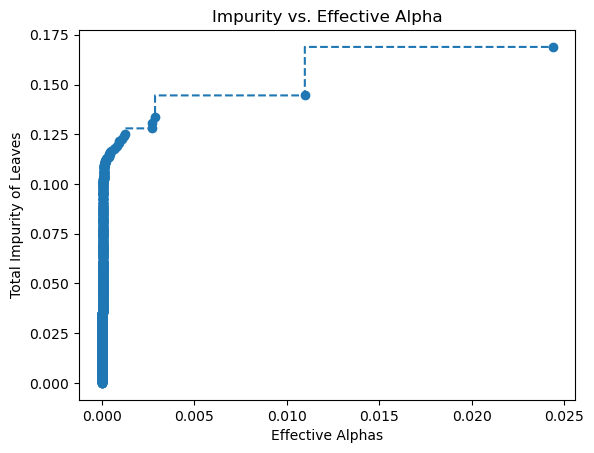

In [65]:
# graphically show the relation between impure nodes and the ccp alpha values
plt.step(ccp_alphas[:-1], impurities[:-1], '--o')
plt.title('Impurity vs. Effective Alpha')
plt.xlabel('Effective Alphas')
plt.ylabel('Total Impurity of Leaves');

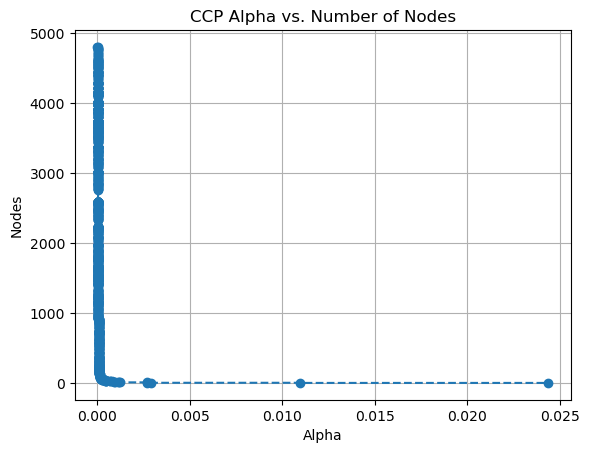

In [66]:
# graphically show the ccp alpha in relation to the number of optimal nodes
plt.step(ccp_alphas[:-1], nodes, '--o')
plt.xlabel('Alpha')
plt.ylabel('Nodes')
plt.title('CCP Alpha vs. Number of Nodes')
plt.grid()

Best score using all features: 0.9164845836368051 <-> CCP Alpha: 0.00018104179553186245 - depth: 8 - nodes: 67


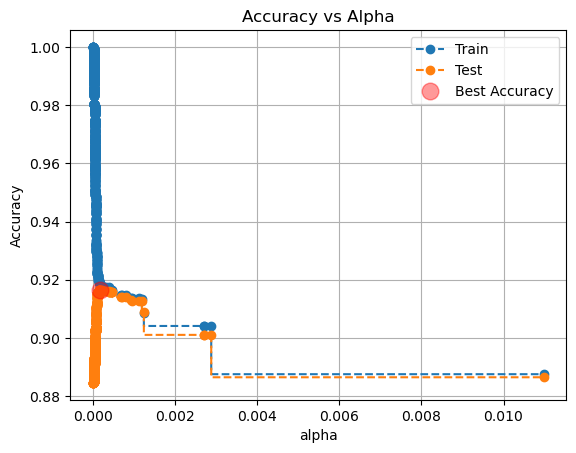

In [ ]:
# show the accuracy for each ccp alpha including the best accuracy score
plt.step(ccp_alphas[:-2], train_accs[:-1], '--o', label = 'Train')
plt.step(ccp_alphas[:-2], test_accs[:-1], '--o', label = 'Test')
plt.plot(ccp_alphas[np.argmax(test_accs)], max(test_accs), 'ro', markersize = 12, alpha = 0.4, label = 'Best Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy vs Alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')

ccp_alpha_best_idx = np.argmax(test_accs)
print(f"Best score using all features: {max(test_accs)} <-> CCP Alpha: {ccp_alphas[ccp_alpha_best_idx]} - depth: {depths[ccp_alpha_best_idx]} - nodes: {nodes[ccp_alpha_best_idx]}")

#### 11D (continued) 
A Grid-Search was performed using the CCP Alpha values and the feature sets extracted using Logistic Regression.  The actual list of ccp_alpha values range from 0 thru 0.001.  After extracting this range of values I ended up only using 10% of these values due to the size of the extracted list (1000 values).  Furthermore, I made sure to use the best ccp_alpha value that was found while fitting and scoring the training and test data in the previous step.

It should be noted that the previously defined feature sets that were used for fitting and testing Logistic Regression (11B) were used here.

In [ ]:
# Fit the DTC model using CCP Alpha values that are around 0 while fiting said models using the 5 feature sets derived when performing Logistic Regression

# load data dictionary with selected features
lr_selected_feature_results = load_map_from_json('data/lr_selected_feature_results.json')

# extract best ccp_alpha values and place them in an ordered array
ccp_alpha_approx_zeros = []
for i in ccp_alphas[:-1]:
    if i >=0 and i <= 0.001 :
        ccp_alpha_approx_zeros.append(i)

print('ccp_alpha array size: ', len(ccp_alpha_approx_zeros))

# evenly copy 10% of the ccp_alpha values plus the best that was found
# during the previous step
best_ccp_alpha_list = ccp_alpha_approx_zeros[::100]
best_ccp_alpha_list.append(ccp_alphas[ccp_alpha_best_idx])

# set hyperparameters for grid search
hyperparams = {'decisiontree__ccp_alpha': best_ccp_alpha_list}

# Evaluate Decision Tree classifier models for each set of features
best_model_results = []
for selected_feature_list in lr_selected_feature_results.values() :
    preprocessor = ColumnTransformer(
        transformers=[
            ('selected_features', StandardScaler(), selected_feature_list),
        ])
    model_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('decisiontree', DecisionTreeClassifier(random_state=42))
                    ])
    model_grid = GridSearchCV(model_pipe, param_grid=hyperparams, cv=5, n_jobs=-1)
    
    start_time = time.time()
    model_grid.fit(X_train[selected_feature_list], y_train)
    fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time']) 

    # Get the best estimator
    best_model = model_grid.best_estimator_
    print(model_grid.best_params_)
    print(model_grid.best_estimator_)

    train_score = best_model.score(X_train[selected_feature_list], y_train)
    test_score = best_model.score(X_test[selected_feature_list], y_test)

    best_model_results.append([len(selected_feature_list), model_grid.best_params_, train_score, test_score, fit_time])

# Create the results DataFrame
best_model_results_df = pd.DataFrame(best_model_results, columns=['feature count', 'best params', 'train score', 'test score', 'average fit time'])
best_model_results_df.reset_index(inplace=True)
best_model_results_df.to_json('data/dtc_model_results_df.json', orient='records', double_precision=10)


ccp_alpha array size:  1009
{'decisiontree__ccp_alpha': 0.00042368419946236906}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['contact_duration_seconds',
                                                   'days_since_last_contact',
                                                   'number_employed_quarterly'])])),
                ('decisiontree',
                 DecisionTreeClassifier(ccp_alpha=0.00042368419946236906,
                                        random_state=42))])
{'decisiontree__ccp_alpha': 0.00018104179553186245}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['age',
                                                   'conta

#### Decision Tree Classifier Results (11D)
It would appear that the best CPP_ALPHA was 0.000181 with an accuracy score of 0.91 (91%) and an average fit time ranging between 0.07 and 0.22 seconds.  The best model was determined based on average fit time.  This result in record set to index 1 where the average fit time was 0.07 seconds.

In [73]:
dtc_results_df = pd.read_json('data/dtc_model_results_df.json')
dtc_results_df

,index,feature count,best params,train score,test score,average fit time
0,0,3,{'decisiontree__ccp_alpha': 0.0004236842000000...,0.913687,0.912843,0.296097
1,1,7,{'decisiontree__ccp_alpha': 0.0001810418},0.918118,0.916606,0.066945
2,2,9,{'decisiontree__ccp_alpha': 0.0001810418},0.918118,0.916606,0.073536
3,3,33,{'decisiontree__ccp_alpha': 0.0001810418},0.918149,0.916849,0.158197
4,4,46,{'decisiontree__ccp_alpha': 0.0001810418},0.918270,0.916485,0.213811
5,5,50,{'decisiontree__ccp_alpha': 0.0001810418},0.918270,0.916485,0.226309


#### 11E Improving performance of the model derived using Support Vector Machines (SVC)
There were two evaluation generated using grid-search API.

Attempt 1: The following hyperparameter types were used in this exercise:
- Coefficient (C): 0.1, 1, 10 [going from larger margins to smaller margins/less misclassifications]
- kernel: 'rbf', 'linear', 'poly', 'linear', 'sigmoid'

During this attempt gamma was left as the default ('scale') which allows it to be calculated based on the number of features and the variance of the data.  In the next attempt the gamma value was set in a effort to do a side by side evaluation using the same feature sets.  In that attempt only the 'rbf' kernel was tested due to the results of the first attempt where all the best fits used that same kernel.

Attempt 2: The following hyperparameter types were used in this exercise:
- gamma: 0.1, 1, 10
- kernel: 'rbf'

During both attempts the grid search API was configured to use k-fold cross validation with 5 folds.

The same features sets used to test the previous models were used to evaluate these models.


In [ ]:
# Attempt 1:

# load data dictionary with selected features
lr_selected_feature_results = load_map_from_json('data/lr_selected_feature_results.json')

# set hyperparameters for grid search
hyperparams = {
                'svc__C': [0.1, 1, 10],
                'svc__kernel': ['linear', 'rbf', 'poly', 'linear', 'sigmoid']
            }

# Evaluate SVM classifier models for each set of features
best_model_results = []
for selected_feature_list in lr_selected_feature_results.values() :
    preprocessor = ColumnTransformer(
        transformers=[
            ('selected_features', StandardScaler(), selected_feature_list),
        ])
    model_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('svc', SVC())
                    ])
    model_grid = GridSearchCV(model_pipe, param_grid=hyperparams, cv=5, n_jobs=-1)
    
    start_time = time.time()
    model_grid.fit(X_train[selected_feature_list], y_train)
    fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time']) 

    # Get the best estimator
    best_model = model_grid.best_estimator_
    print(model_grid.best_params_)
    print(model_grid.best_estimator_)

    train_score = best_model.score(X_train[selected_feature_list], y_train)
    test_score = best_model.score(X_test[selected_feature_list], y_test)

    best_model_results.append([model_grid.best_params_['svc__kernel'], len(selected_feature_list), model_grid.best_params_, train_score, test_score, fit_time])

# Create the results DataFrame
best_model_results_df = pd.DataFrame(best_model_results, columns=['kernel', 'feature count', 'best params', 'train score', 'test score', 'average fit time'])
best_model_results_df.reset_index(inplace=True)
best_model_results_df.to_json('data/svc1_model_results_df.json', orient='records', double_precision=10)


{'svc__C': 10, 'svc__kernel': 'rbf'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['contact_duration_seconds',
                                                   'days_since_last_contact',
                                                   'number_employed_quarterly'])])),
                ('svc', SVC(C=10))])
{'svc__C': 10, 'svc__kernel': 'rbf'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['age',
                                                   'contact_duration_seconds',
                                                   'days_since_last_contact',
                                                   'consumer_price_index_monthly',
     

In [ ]:
svc1_results_df = pd.read_json('data/svc1_model_results_df.json')
svc1_results_df


,index,kernel,feature count,best params,train score,test score,average fit time
0,0,rbf,3,"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.913839,0.912357,13.811653
1,1,rbf,7,"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.917420,0.913571,31.223945
2,2,rbf,9,"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.918816,0.913086,25.178635
3,3,rbf,33,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.921973,0.909808,43.309508
4,4,rbf,46,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.925857,0.908716,98.412536
5,5,rbf,50,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.926646,0.908230,123.570755


In [ ]:
# Attempt 2:

# load data dictionary with selected feature sets
lr_selected_feature_results = load_map_from_json('data/lr_selected_feature_results.json')

# set hyperparameters for grid search for all available kernels and gamma ranging from 0.1 to 100.0
hyperparams = {
                'svc__gamma': [0.1, 1.0, 10],
                'svc__kernel': ['rbf']
            }

# Evaluate Support Vector Machine classifier models for each set of features
best_model_results = []
for selected_feature_list in lr_selected_feature_results.values() :
    preprocessor = ColumnTransformer(
        transformers=[
            ('selected_features', StandardScaler(), selected_feature_list),
        ])
    model_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('svc', SVC())
                    ])
    model_grid = GridSearchCV(model_pipe, param_grid=hyperparams, cv=5, n_jobs=-1, verbose=100)
    
    start_time = time.time()
    model_grid.fit(X_train[selected_feature_list], y_train)
    fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time']) 

    # Get the best estimator
    best_model = model_grid.best_estimator_
    print(model_grid.best_params_)
    print(model_grid.best_estimator_)

    train_score = best_model.score(X_train[selected_feature_list], y_train)
    test_score = best_model.score(X_test[selected_feature_list], y_test)

    best_model_results.append([model_grid.best_params_['svc__kernel'], len(selected_feature_list), model_grid.best_params_, train_score, test_score, fit_time])

# Create the results DataFrame
best_model_results_df = pd.DataFrame(best_model_results, columns=['kernel', 'feature count', 'best params', 'train score', 'test score', 'average fit time'])
best_model_results_df.reset_index(inplace=True)
best_model_results_df.to_json('data/svc2_model_results_df.json', orient='records', double_precision=10)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'svc__gamma': 1.0, 'svc__kernel': 'rbf'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['contact_duration_seconds',
                                                   'days_since_last_contact',
                                                   'number_employed_quarterly'])])),
                ('svc', SVC(gamma=1.0))])
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'svc__gamma': 1.0, 'svc__kernel': 'rbf'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('selected_features',
                                                  StandardScaler(),
                                                  ['age',
                                                   'contact_duration_seconds',
                               

In [70]:
svc2_results_df = pd.read_json('data/svc2_model_results_df.json')
svc2_results_df

,index,kernel,feature count,best params,train score,test score,average fit time
0,0,rbf,3,"{'svc__gamma': 1.0, 'svc__kernel': 'rbf'}",0.914659,0.912479,10.817299
1,1,rbf,7,"{'svc__gamma': 1.0, 'svc__kernel': 'rbf'}",0.922640,0.913450,15.589033
2,2,rbf,9,"{'svc__gamma': 1.0, 'svc__kernel': 'rbf'}",0.928892,0.911872,26.509179
3,3,rbf,33,"{'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.942155,0.907380,137.106734
4,4,rbf,46,"{'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.963581,0.899976,206.688920
5,5,rbf,50,"{'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.965979,0.897912,221.755881


## (11E Continued) Comparison of both Attempts
Here I performed a comparison of the best results from both attempts with regards to the hyperparameters used.  

It would appear that the regularization parameter (C) and gamma were comperable, with regards to accuracy and performance, while using the gaussian kernel (rbf) as shown in the first two records in the follwing table.
- Gamma: When the RBF kernel is used gamma values should normally be between 3/k and 6/k, where k is the number of input features. For example, if there are 3 features, values between 1 and 2 would be worth trying. This was the logic used when setting gamma.
- Cost regularization (C): In general with smaller values tolerate larger margins, causing more misclassifications and larger values producing the opposite affect.  For this reason values of 0.1, 1 and 10 were used during testing.

It was also noted that models with fewer features seemed to provide better performance while not giving up any accuracy.

Finally, you will note that there are extra svc1 files (a thru c).  These file contained the results of similar tests that used the other three kernels

In [ ]:
# load results from files for comparison
svc1_results_df = pd.read_json('data/svc1_model_results_df.json')
svc2_results_df = pd.read_json('data/svc2_model_results_df.json')

# round and sort by 'test score' and 'average fit time' columns, putting the best results at the top
svcall_results_df = pd.concat([svc1_results_df, svc2_results_df]).round(decimals={'test score':2, 'average fit time':3}).sort_values(by=['test score', 'average fit time'], ascending=[False, True])

svcall_results_df



,index,kernel,feature count,best params,train score,test score,average fit time
0,0,rbf,3,"{'svc__gamma': 1.0, 'svc__kernel': 'rbf'}",0.914659,0.91,10.817
0,0,rbf,3,"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.913839,0.91,13.812
1,1,rbf,7,"{'svc__gamma': 1.0, 'svc__kernel': 'rbf'}",0.922640,0.91,15.589
2,2,rbf,9,"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.918816,0.91,25.179
2,2,rbf,9,"{'svc__gamma': 1.0, 'svc__kernel': 'rbf'}",0.928892,0.91,26.509
1,1,rbf,7,"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.917420,0.91,31.224
3,3,rbf,33,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.921973,0.91,43.310
4,4,rbf,46,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.925857,0.91,98.413
5,5,rbf,50,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.926646,0.91,123.571
3,3,rbf,33,"{'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.942155,0.91,137.107


## 12 Final Comparison of Results
Here is where I compare the best results from each model in an effort to identify the best approach for predicting

It was determined from that output in the following table that the decision tree classifier produced the best combination of test-score accuracy and average fit time, followed by KNearest Neighbor and Logistic Regression.  The configuration of this model can be seen in the next table were the columns are defined as follows.
- feature count: number of features used to fit the model
- best params: the model type and parameters used to configure the target modeling tool
- train score - accuracy score when training the model
- test score - accuracy score when testing the model
- average fit time - average mean time to fit the model using the configuration found in 'best params' and the numer of feature columns

For the best performing model that was generated using the Decision Tree Classifier, the configuration is as follows:
- ccp_alpha: 0.0001810418
- feature count: 7 (the list of features are defined below)

The list of features that were either used directly or transformed from the original catagorical information into numeric information are as follows:
- age
- duration
- pdays
- cons.price.idx
- cons.conf.idx
- euribor3m
- nr.employed

Transformed/renamed columns:
- 'age' - unchanged
- 'contact_duration_seconds' - column renamed from 'duration'
- 'days_since_last_contact' - column renamed from 'pdays'
- 'consumer_price_index_monthly' - column renamed from 'cons.price.idx'
- 'consumer_confidence_index_monthly' - column renamed from 'con.conf.idx'
- 'euribor3_monthly_rate_daily' - column renamed from 'euribor3m'
- 'number_employed_quarterly' - column renamed from 'nr.employed'

There were also several secondary columns that were evaluated and could be considered important in future attempts at enhancing this model.  They are as follows:
- campain
- month

Transformed/renamed columns
- contact_attempts_during_campaign - column renamed from 'campain'
- month_last_contact_aug  - column renamed from 'month' and transformed to numeric data by month
- month_last_contact_dec  - column renamed from 'month' and transformed to numeric data by month
- month_last_contact_jul  - column renamed from 'month' and transformed to numeric data by month
- month_last_contact_jun  - column renamed from 'month' and transformed to numeric data by month
- month_last_contact_mar  - column renamed from 'month' and transformed to numeric data by month
- month_last_contact_may  - column renamed from 'month' and transformed to numeric data by month
- month_last_contact_nov  - column renamed from 'month' and transformed to numeric data by month
- month_last_contact_oct  - column renamed from 'month' and transformed to numeric data by month
- month_last_contact_sep  - column renamed from 'month' and transformed to numeric data by month

In [129]:
# load results from files for comparison
svc1_results_df = pd.read_json('data/svc1_model_results_df.json')
svc2_results_df = pd.read_json('data/svc2_model_results_df.json')
lr_results_df = pd.read_json('data/lr_model_per_coef_results_df.json')
knn_results_df = pd.read_json('data/knn_model_results_df.json')
dtc_results_df = pd.read_json('data/dtc_model_results_df.json')

# round and sort by 'test score' and 'average fit time' columns, putting the best results at the top
finale_model_results_df = pd.concat([svc1_results_df, svc2_results_df, lr_results_df, dtc_results_df, knn_results_df]).round(decimals={'test score':2, 'average fit time':3}).sort_values(by=['test score', 'average fit time'], ascending=[False, True])

# set column order
column_order = ['kernel', 'coef', 'feature count', 'best params', 'train score', 'test score', 'average fit time']
finale_model_results_df =  finale_model_results_df.reindex(columns=column_order)

finale_model_results_df



,kernel,coef,feature count,best params,train score,test score,average fit time
1,NaN,NaN,7,{'decisiontree__ccp_alpha': 0.0001810418},0.918118,0.92,0.067
2,NaN,NaN,9,{'decisiontree__ccp_alpha': 0.0001810418},0.918118,0.92,0.074
3,NaN,NaN,33,{'decisiontree__ccp_alpha': 0.0001810418},0.918149,0.92,0.158
4,NaN,NaN,46,{'decisiontree__ccp_alpha': 0.0001810418},0.918270,0.92,0.214
5,NaN,NaN,50,{'decisiontree__ccp_alpha': 0.0001810418},0.918270,0.92,0.226
2,NaN,0.002276,9,"{'logisticregression__penalty': 'l2', 'logisti...",0.908316,0.91,0.166
1,NaN,NaN,7,"{'knn__n_neighbors': 21, 'knn__p': 2, 'knn__we...",0.919059,0.91,0.211
0,NaN,NaN,3,"{'knn__n_neighbors': 19, 'knn__p': 1, 'knn__we...",0.917754,0.91,0.217
0,NaN,NaN,3,{'decisiontree__ccp_alpha': 0.0004236842000000...,0.913687,0.91,0.296
2,NaN,NaN,9,"{'knn__n_neighbors': 21, 'knn__p': 1, 'knn__we...",0.919211,0.91,0.331


##### Questions

1. Can the selected modeling tools be configure to be more accurate ( >92% ) using different combinations of features?

2. What other modeling tools are there that might perform better than the ones selected?